In [4]:
# Add the parent directory of the current working directory to the Python path at runtime. 
# In order to import modules from the src directory.
import os
import sys 

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [5]:
import numpy as np
import tomllib
from scipy import ndimage
import matplotlib.pyplot as plt

from src.v1_model import V1Model


In [6]:
def load_configurations():
    """
    Load the model, stimulus, simulation, and experiment parameters.

    Returns
    -------
    model_parameters : dict
        The model parameters.
    stimulus_parameters : dict
        The stimulus parameters.
    simulation_parameters : dict
        The simulation parameters.
    experiment_parameters : dict
        The experiment parameters.
    """
    parameters = {}
    config_files = ['model', 'stimulus', 'simulation']

    for config_file in config_files:
        with open(f'../config/simulation/{config_file}.toml', 'rb') as f:
            parameters[config_file] = tomllib.load(f)

    with open('../config/analysis/experiment_extended.toml', 'rb') as f:
        parameters['experiment_extended'] = tomllib.load(f)

    return parameters['model'], parameters['stimulus'], parameters[
        'simulation'], parameters['experiment_extended']

In [7]:
model_parameters, stimulus_parameters, simulation_parameters, experiment_parameters = load_configurations()

In [8]:
model = V1Model(model_parameters, stimulus_parameters)

In [9]:
def weighted_kuramoto(orientation_map, receptive_fields):
    """
    Compute the Kuramoto order parameter of the orientation map weighted by the receptive fields of each neural population.

    Parameters
    ----------
    orientation_map : np.ndarray
        The orientation map.

    receptive_fields : np.ndarray
        The receptive fields of all neural populations.

    Returns
    -------
    np.ndarray
        The weighted Kuramoto order parameter.
    """
    orientation_map = orientation_map.flatten()

    # Compute the complex representation of the orientation
    complex_orientation = np.exp(1j * orientation_map)

    # Compute the weighted Kuramoto order parameter
    order_parameter = receptive_fields.dot(complex_orientation)

    return np.angle(order_parameter)

def orientation_response(preferred_orientations, input_orientations, sigma=np.pi / 2):
    """
    Compute the orientation response using a Gaussian tuning curve.

    Parameters
    ----------
    preferred_orientatiosn : np.ndarray
                The preferred orientation of the unit.
        input_orientation : np.ndarray
            The input orientation for the unit.
        sigma : float, optional
            The tuning width of the orientation response. Default is pi/2.

        Returns
        -------
        response : np.ndarray
            The orientation response of the unit.
        """
    angular_distance = np.angle(
            np.exp((preferred_orientations - input_orientations) * 2j))
    return np.exp(-angular_distance**2 / (8 * sigma**2))

In [10]:
class StimulusGenerator:

    def __init__(self, parameters):
        self.stimulus_resolution = parameters['stimulus_resolution']
        self.patch_type = parameters.get('patch_type', 'orientation')  # Patch type: 'annulus' or 'orientation'
        self.patch_resolution = parameters['patch_resolution']

        if self.patch_type == 'annulus':
            self.annulus_diameter = parameters['annulus_diameter']
            annulus_frequency = parameters['annulus_frequency']
            self.annulus = self._create_annulus(self.annulus_diameter, annulus_frequency)
        elif self.patch_type == 'orientation':
            self.orientation_diameter = parameters['orientation_diameter']
            self.reference_orientation = parameters['reference_orientation']
            self.heterogeneity = parameters['heterogeneity']
            self.orientation_frequency = parameters['orientation_frequency']

    def generate(self, scaling_factor):
        """
        Generate a stimulus.

        Parameters
        ----------
        scaling_factor : float
            The scaling factor for the grid.

        Returns
        -------
        array_like
            The generated stimulus.
        """
        grid = self._get_grid(scaling_factor)
        stimulus_grid = np.ones((self.stimulus_resolution, self.stimulus_resolution)) * 0.5
        indices = np.arange(self.patch_resolution)
        patch_half_res = self.patch_resolution // 2
        for row, col in grid:
            left, right = row - patch_half_res, row + patch_half_res
            down, up = col - patch_half_res, col + patch_half_res

            lower_row, upper_row = np.clip([left, right], 0, self.stimulus_resolution)
            lower_col, upper_col = np.clip([down, up], 0, self.stimulus_resolution)

            range_row = upper_row - lower_row
            range_col = upper_col - lower_col

            if left < 0:
                row_indices = indices[-range_row:]
            else:
                row_indices = indices[:range_row]

            if down < 0:
                col_indices = indices[-range_col:]
            else:
                col_indices = indices[:range_col]

            if self.patch_type == 'annulus':
                contrast_factor = np.random.uniform(
                    0.5 - 0.2,
                    0.5 + 0.2)
                patch = self.annulus[row_indices, :][:, col_indices] * contrast_factor
            elif self.patch_type == 'orientation':
                orientation_factor = np.random.uniform(
                    self.reference_orientation - 90 * self.heterogeneity, #value of 90 taken from oriented_annulus code
                    self.reference_orientation + 90 * self.heterogeneity)
                patch = self._create_orientation_grating(orientation_factor, self.orientation_diameter, self.orientation_frequency)[row_indices, :][:, col_indices]
            else:
                patch = np.zeros((range_row, range_col))  # Ensures patch is always assigned

            stimulus_grid[lower_row:upper_row, lower_col:upper_col] = patch + 0.5

        return stimulus_grid

    def _get_grid(self, scaling_factor):
        """
        Generate a grid with a specified scaling factor.

        Parameters
        ----------
        scaling_factor : float
            The scaling factor for the grid.

        Returns
        -------
        array_like
            The generated grid.
        """
        step_size = int(self.patch_resolution * scaling_factor)
        patch_quarter_res = self.patch_resolution // 4
        grid_points = np.arange(patch_quarter_res, self.stimulus_resolution + step_size, step_size)
        row_grid, col_grid = np.meshgrid(grid_points, grid_points)
        grid = np.vstack((row_grid.flatten(), col_grid.flatten())).T

        randomness = (self.patch_resolution * scaling_factor - self.patch_resolution) // 2
        if randomness > 0:
            grid += np.random.randint(-randomness, randomness, size=grid.shape)

        return grid

    def _create_annulus(self, annulus_diameter, frequency):
        """
        Create an annulus patch.

        Parameters
        ----------
        annulus_diameter : float
            The annulus_diameter of the annulus.
        frequency : float
            The spatial frequency of the radial modulation.

        Returns
        -------
        array_like
            The annulus patch.
        """
        r = np.linspace(-annulus_diameter / 2, annulus_diameter / 2, self.patch_resolution)
        x, y = np.meshgrid(r, -r)
        radius = np.hypot(x, y)
        mask = radius <= annulus_diameter / 2
        annulus = 0.5 * np.cos(radius * frequency * 2 * np.pi + np.pi) * mask
        return annulus

    def _create_orientation_grating(self, orientation, annulus_diameter, frequency):
        """
        Create a single orientation grating.

        Parameters
        ----------
        orientation : float
            The orientation of the grating in degrees.
        annulus_diameter : float
            The annulus_diameter of the orientation patch (to match annulus size).
        frequency : float
            The spatial frequency of the orientation grating.

        Returns
        -------
        array_like
            The orientation grating.
        """
        radius = annulus_diameter / 2
        r = np.linspace(-radius, radius, self.patch_resolution)
        x, y = np.meshgrid(r, -r)
        y = -y
        x_rot = self._rotate_x(x, y, orientation)
        grating = np.sin(2 * np.pi * frequency * x_rot)  # Frequency is now adjustable
        eccentricity = np.abs(x + y * 1j)
        mask = eccentricity <= radius  # Circular mask
        return grating * mask

    @staticmethod
    def _rotate_x(x, y, rotation_angle):
        """
        Rotate the x-coordinates.

        Parameters
        ----------
        x : array_like
            The x-coordinates.
        y : array_like
            The y-coordinates.
        rotation_angle : float
            The rotation angle in degrees.

        Returns
        -------
        array_like
            The rotated x-coordinates.
        """
        radian = np.radians(rotation_angle)
        return np.cos(radian) * x + np.sin(radian) * y

In [11]:
def gabor_filter_bank(image, frequency, orientations, sigma=1.0):
    """
    Apply a Gabor filter bank to an image to extract orientation information.

    Parameters:
    - image: 2D numpy array representing the grayscale image.
    - frequency: Wavelength of the sinusoidal factor.
    - orientations: List of orientations (theta) in radians.
    - sigma: Standard deviation of the Gaussian envelope.

    Returns:
    - orientation_map: 2D numpy array with the estimated orientation at each pixel.
    - max_response: 2D numpy array with the maximum filter response at each pixel.
    """
    rows, cols = image.shape
    response_stack = np.zeros((len(orientations), rows, cols))
    
    for i, theta in enumerate(orientations):
        # Create Gabor filter kernel
        kernel = gabor_kernel(frequency, theta, sigma_x=sigma, sigma_y=sigma)
        # Apply filter to image
        filtered = ndimage.convolve(image, np.real(kernel), mode='reflect')
        # Compute magnitude of response
        response = np.abs(filtered)
        # Accumulate maximum response over frequencies
        response_stack[i] = np.maximum(response_stack[i], response)
    
    # Determine the orientation with the maximum response at each pixel
    max_response = np.max(response_stack, axis=0)
    orientation_indices = np.argmax(response_stack, axis=0)
    orientation_map = orientations[orientation_indices]
    
    return orientation_map, max_response

def gabor_kernel(frequency, theta, sigma_x, sigma_y):
    """
    Generate a Gabor filter kernel.

    Parameters:
    - frequency: Wavelength of the sinusoidal factor.
    - theta: Orientation angle in radians.
    - sigma_x, sigma_y: Standard deviations of the Gaussian envelope.

    Returns:
    - kernel: 2D numpy array representing the Gabor kernel.
    """
    # Define kernel size
    nstds = 3  # Number of standard deviations to include in the kernel size
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = np.ceil(max(1, ymax))
    x = np.linspace(-xmax, xmax, int(2 * xmax + 1))
    y = np.linspace(-ymax, ymax, int(2 * ymax + 1))
    x, y = np.meshgrid(x, y)

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    # Gabor kernel
    kernel = np.exp(-0.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)) * \
             np.exp(1j * (2 * np.pi * frequency * x_theta))
    
    return kernel

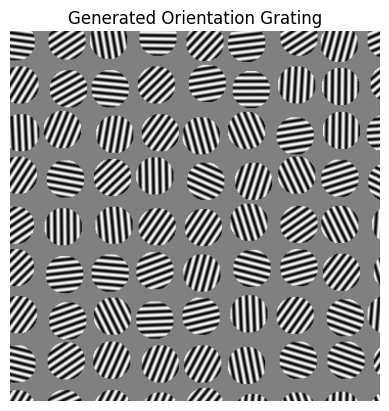

In [12]:

parameters_orientation = {
    'stimulus_resolution': 480,
    'patch_resolution': 50,
    'patch_type': 'orientation',
    'orientation_diameter': 1,
    'reference_orientation': 45,
    'heterogeneity': 0.8,
    'orientation_frequency': 5.7,  # Frequency parameter for orientation patch
}

stimulus_gen = StimulusGenerator(parameters_orientation)
stimulus = stimulus_gen.generate(scaling_factor=1.2)

plt.imshow(stimulus, cmap='gray')
plt.title('Generated Orientation Grating')
plt.axis('off')
plt.show()

In [13]:
def convert_frequencies(stimulus_parameters):
    """
    Convert the orientation frequency to cycles per pixel.
    """
    return stimulus_parameters['orientation_frequency'] / stimulus_parameters['patch_resolution']   

def compute_sigma(frequency, bandwidth=1):
    """
    Compute the standard deviation of the Gaussian envelope for the Gabor filter bank.
    """
    bandwidth_factor = (2**bandwidth + 1) / (2**bandwidth - 1)
    return bandwidth_factor * np.sqrt(np.log(2)) / (frequency * np.pi)

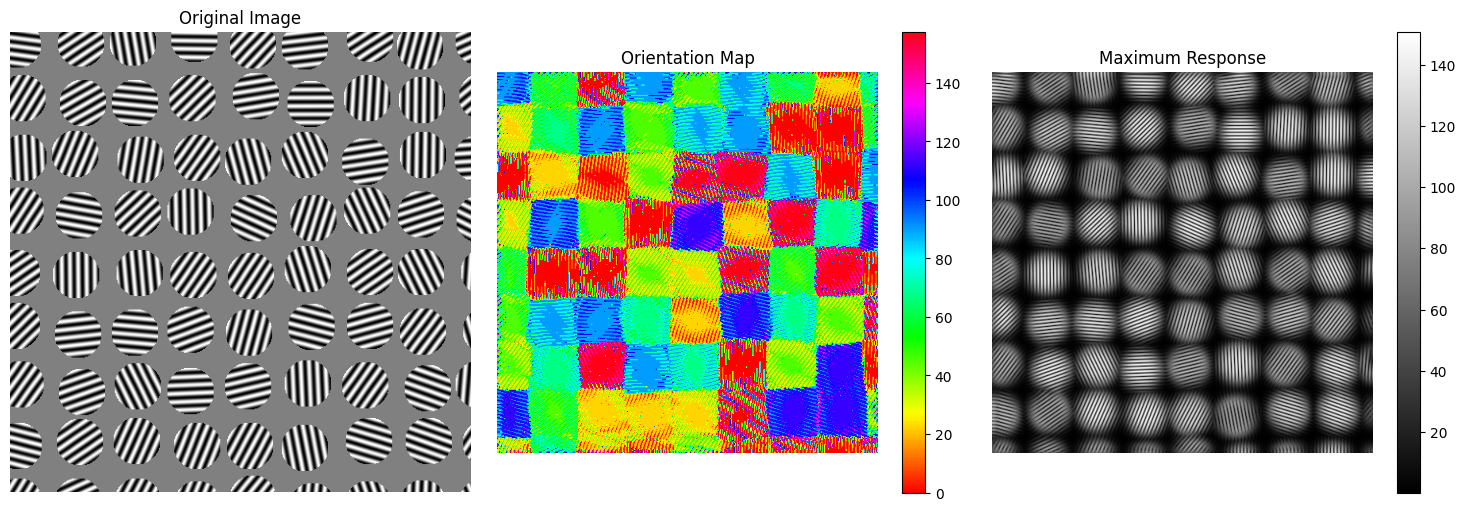

In [14]:
# Extract orientation information using Gabor filter bank
# Define frequencies and orientations
converted_frequency = convert_frequencies(parameters_orientation)
sigma = compute_sigma(converted_frequency, bandwidth=1)
orientations = np.linspace(0, np.pi, 8, endpoint=False)

# Compute orientation map using Gabor filter bank
orientation_map, max_response = gabor_filter_bank(stimulus, converted_frequency, orientations, sigma=sigma)

# Display the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(stimulus, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Orientation Map
plt.subplot(1, 3, 2)
plt.imshow(orientation_map / np.pi * 180, cmap='hsv')
plt.title('Orientation Map')
plt.colorbar()
plt.axis('off')

# Maximum Response
plt.subplot(1, 3, 3)
plt.imshow(max_response, cmap='gray')
plt.title('Maximum Response')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

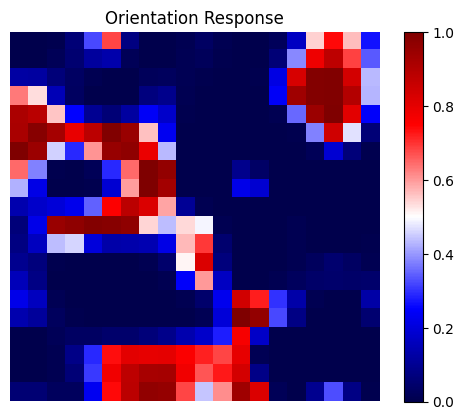

In [16]:
# just for illustration purposes, I will assing all units a preferred orientation of 15 degrees

preferred_orientations = np.ones(model.num_populations) * np.radians(15)

# Compute the weighted Kuramoto order parameter
weighted_kuramoto_order = weighted_kuramoto(orientation_map, model.receptive_fields)

# Compute the orientation response of the model units
response = orientation_response(preferred_orientations, weighted_kuramoto_order, sigma=np.radians(17))

# Display the orientation response
plt.imshow(response.reshape(20,20), cmap='seismic', vmin=0, vmax=1)
plt.title('Orientation Response')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
# Let's assign each population a different preferred orientation. 
# I will now keep the 20x20 grid that we already have but now assign each location 8 populations with different preferred orientations.
# I now also estimated an appropriate sigma for the orientation response function to get realistic tuning curves.
tuning_width = 17
sigma = np.radians(tuning_width)

column = np.linspace(0, np.pi, 8, endpoint=False)
# repeat the column 400 times on a 20x20 grid with the column as a new third axis
preferred_orientations = np.zeros((20, 20, 8))
preferred_orientations[:, :, :] = column
preferred_orientations = preferred_orientations.flatten()

# Compute the weighted Kuramoto order parameter
weighted_kuramoto_order = weighted_kuramoto(orientation_map, model.receptive_fields)

# Compute the orientation response of the model units
response = orientation_response(preferred_orientations, weighted_kuramoto_order, sigma)

ValueError: operands could not be broadcast together with shapes (3200,) (400,) 

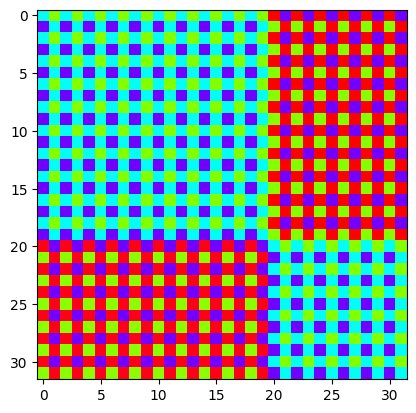

In [37]:
def compute_angular_differences(preferred_orientations):
    """Compute the angular differences between neurons."""
    angular_differences = preferred_orientations[:, np.newaxis] - preferred_orientations[np.newaxis, :]
    return np.angle(np.exp(2j * angular_differences)) / 2

# Compute the angular differences between neurons
angular_differences = compute_angular_differences(preferred_orientations)

plt.imshow(angular_differences[:32,:32], cmap='hsv')

In [ ]:
column = np.linspace(0, np.pi, 8, endpoint=False)
# repeat the column 400 times on a 20x20 grid with the column as a new third axis
preferred_orientations = np.zeros((20, 20, 8))
preferred_orientations[:, :, :] = column
preferred_orientations.shape

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])